## Day 30 Lecture 2 Assignment

In this assignment, we will learn about random forests. We will use the google play store dataset loaded below.

In [1]:
!pip install category_encoders

In [15]:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import graphviz
from sklearn import tree

from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
import category_encoders as ce
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier

In [3]:
reviews = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/googleplaystore.csv')

reviews.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In this assignment, you will work more independently. Perform the following steps:
    
1. Select which columns are best suited to predict whether the rating is above 4.5
2. Process the data (including transforming to the correct column type, removing missing values, creating dummy variables, and removing irrelevant variables)
3. Create a random forest model and evaluate
4. Using grid search cross validation, tweak the parameters to produce a better performing model
5. Show and discuss your results

Good luck!

In [4]:
feature_df = reviews.copy()
feature_df.dropna(inplace=True)

In [5]:
feature_df['Reviews'] = pd.to_numeric(feature_df['Reviews'], errors='coerce', downcast='integer')
feature_df['Price'] = feature_df['Price'].str.strip('$')
feature_df['Price'] = feature_df['Price'].astype(float)

In [6]:
feature_df.select_dtypes(include='O').nunique().sort_values(ascending=False)

App               8190
Current Ver       2638
Last Updated      1299
Size               413
Genres             115
Category            33
Android Ver         31
Installs            19
Content Rating       6
Type                 2
dtype: int64

In [7]:
for col in feature_df.select_dtypes(include='O').columns:
  print(f'\n{col} value counts:')
  print(feature_df[col].value_counts(dropna=False))


App value counts:
ROBLOX                                                   9
CBS Sports App - Scores, News, Stats & Watch Live        8
Candy Crush Saga                                         7
ESPN                                                     7
8 Ball Pool                                              7
                                                        ..
Web Browser & Fast Explorer                              1
Manga Books                                              1
yHomework - Math Solver                                  1
XML Editor CR                                            1
Viva Decora - Decoration, Photos, Architecture, House    1
Name: App, Length: 8190, dtype: int64

Category value counts:
FAMILY                 1746
GAME                   1097
TOOLS                   733
PRODUCTIVITY            351
MEDICAL                 350
COMMUNICATION           328
FINANCE                 323
SPORTS                  319
PHOTOGRAPHY             317
LIFESTYLE         

In [8]:
feature_df.drop(['App', 'Size', 'Last Updated', 'Current Ver', 'Android Ver', 'Price', 'Genres'], axis =1, inplace=True)

maybe_features = ['Installs', 'Category', 'Genres', 'Price']

feature_df.drop(feature_df[feature_df['Content Rating']=='Unrated'].index, inplace=True)
feature_df.drop(feature_df[feature_df['Content Rating']=='Adults only 18+'].index, inplace=True)

feature_df.drop(feature_df[feature_df['Installs']=='5+'].index, inplace=True)
feature_df.drop(feature_df[feature_df['Installs']=='1+'].index, inplace=True)

feature_df['Type'] = feature_df['Type'].replace({'Paid': 1, 'Free':0})

feature_df['Rating_Above'] = np.where((feature_df['Rating'] >= 4.5), 1, 0)

feature_df.drop('Rating', 1, inplace=True)

feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9344 entries, 0 to 10840
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Category        9344 non-null   object
 1   Reviews         9344 non-null   int32 
 2   Installs        9344 non-null   object
 3   Type            9344 non-null   int64 
 4   Content Rating  9344 non-null   object
 5   Rating_Above    9344 non-null   int64 
dtypes: int32(1), int64(2), object(3)
memory usage: 474.5+ KB


In [9]:
feature_df.head()

,Category,Reviews,Installs,Type,Content Rating,Rating_Above
0,ART_AND_DESIGN,159,"10,000+",0,Everyone,0
1,ART_AND_DESIGN,967,"500,000+",0,Everyone,0
2,ART_AND_DESIGN,87510,"5,000,000+",0,Everyone,1
3,ART_AND_DESIGN,215644,"50,000,000+",0,Teen,1
4,ART_AND_DESIGN,967,"100,000+",0,Everyone,0


In [10]:
X = feature_df.drop('Rating_Above', 1)
Y = feature_df['Rating_Above']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [11]:
encoder = ce.LeaveOneOutEncoder(cols=['Category', 'Installs', 'Content Rating'])
encoder.fit(X_train, y_train)
X_train_cleaned = encoder.transform(X_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [12]:
params = {'max_depth': [5, 10, 15, 25, 50], 'min_samples_split': [25, 50, 75, 100], 'max_features': ['sqrt', 0.5, None]}

forest = RandomForestClassifier(criterion='entropy')

forest_grid = GridSearchCV(forest, param_grid = params, cv=5)

forest_grid.fit(X_train_cleaned, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [27]:
forest_grid.best_params_

{'max_depth': 15, 'max_features': 0.5, 'min_samples_split': 25}

array([0.24172416, 0.46132866, 0.2150253 , 0.0326562 , 0.04926567])

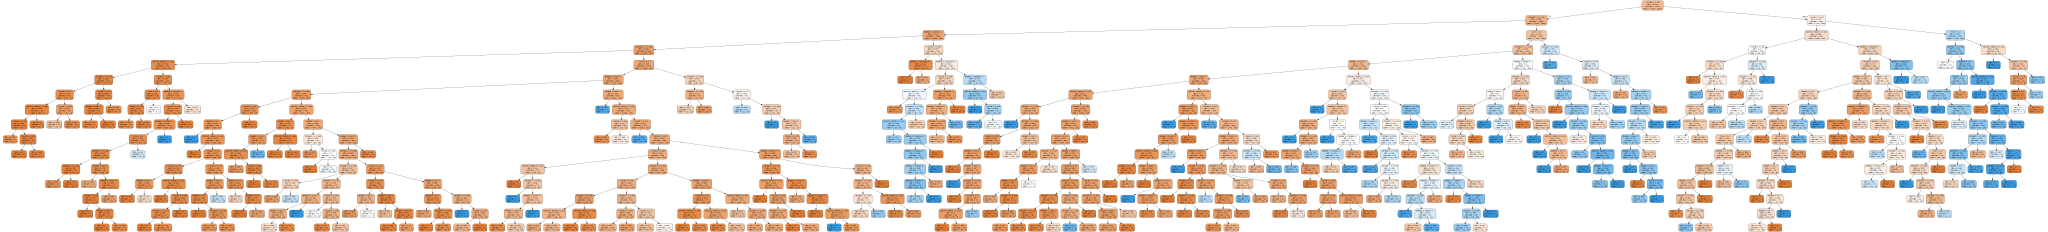

In [39]:
dot_data = tree.export_graphviz(forest_grid.best_estimator_[0], out_file=None,
                                feature_names=X_train_cleaned.columns,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [17]:
X_test_cleaned = encoder.transform(X_test)

y_preds = forest_grid.predict(X_test_cleaned)

In [18]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.76      0.90      0.82      1283
           1       0.63      0.37      0.47       586

    accuracy                           0.73      1869
   macro avg       0.69      0.64      0.64      1869
weighted avg       0.72      0.73      0.71      1869



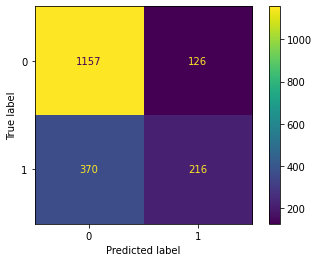

In [33]:
plot_confusion_matrix(forest_grid, X_test_cleaned, y_test, values_format='.5g')
plt.show()

In [34]:
train_score = forest_grid.score(X_train_cleaned, y_train)
test_score = forest_grid.score(X_test_cleaned, y_test)
print('Train Score: {:.4f}'.format(train_score))
print('Test Score: {:.4f}'.format(test_score))

Train Score: 0.8012
Test Score: 0.7346


In [35]:
probs = forest_grid.predict_proba(X_test_cleaned)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probs)

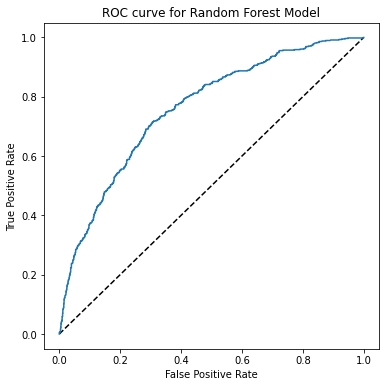

In [36]:
fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Random Forest Model')
plt.show()

In [29]:
forest_importance = pd.Series(forest_grid.best_estimator_.feature_importances_, index=X_train_cleaned.columns).sort_values(ascending=False)
forest_importance

Reviews           0.461329
Category          0.241724
Installs          0.215025
Content Rating    0.049266
Type              0.032656
dtype: float64